---
title: "Data Cleaning"
bread-crumbs: true
sidebar: false
author: "crg123"
date: "2025-04-07"
toc: true
code-fold: true
format:
  html:
    page-layout: article
    embed-resources: true
bibliography: "references.bib"
---

## Data Source & Description 

**Source:**
The data for this analysis was sourced from the Aid Worker Security Database [@aidworkersecurity], a global repository of verified reports on major security incidents affecting aid workers..

**Unit of Analysis:** Each row represents a single, verified incident involving violence against humanitarian aid workers.

**Coverage:**
The data includes killings, kidnappings, and serious injuries sustained by humanitarian personnel from 1997 onward. Victims include national and international staff working for NGOs, UN agencies, and Red Cross/Crescent movements.

**Data Collection Methodology:**
AWSD compiles data through systematic media scraping, direct reports from humanitarian organizations, and field-level security consortia. All records are verified annually with relevant agencies.

**Notes on Confidentiality:**
Victim and agency names are withheld to protect privacy and encourage transparent reporting. Only broad institutional categories are retained.

**Geospatial Precision:**
Most incidents are geocoded using open-source mapping services. When precise coordinates are unavailable, approximate central points are used.

**Citation**:
All analysis using this data should cite: Humanitarian Outcomes. Aid Worker Security Database. 2025 [@aidworkersecurity]. 

## Load and Preview Data

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Tahoma"
import warnings

warnings.filterwarnings("ignore")

In [5]:
# Load data
df = pd.read_csv("data/raw_data/security_incidents.csv")
df.head()

,Incident ID,Year,Month,Day,Country Code,Country,Region,District,City,UN,...,Attack context,Location,Latitude,Longitude,Motive,Actor type,Actor name,Details,Verified,Source
0,1,1997,1.0,NaN,KH,Cambodia,Banteay Meanchey,NaN,NaN,0,...,Unknown,Unknown,14.070929,103.099916,Unknown,Unknown,Unknown,1 ICRC national staff killed while working in ...,Archived,Archived
1,2,1997,1.0,NaN,RW,Rwanda,Northern,Musanze,Ruhengeri,0,...,Raid,Office/compound,-1.499840,29.634970,Unknown,Unknown,Unknown,"3 INGO international (Spanish) staff killed, 1...",Archived,Archived
2,3,1997,2.0,NaN,TJ,Tajikistan,NaN,NaN,NaN,4,...,Unknown,Unknown,38.628173,70.815654,NaN,Unknown,Unknown,"3 UN national staff, 1 UN international (Niger...",Archived,Archived
3,4,1997,2.0,NaN,SO,Somalia,Lower Juba,Kismayo,Kismayo,0,...,Unknown,Unknown,-0.358216,42.545087,Political,Non-state armed group: Regional,Al-Itihaad al-Islamiya,1 INGO international staff killed by Al ittiha...,Archived,Archived
4,5,1997,2.0,14.0,RW,Rwanda,Kigali,Kigali,Kigali,1,...,Individual attack,Unknown,-1.950851,30.061508,Political,Unknown,Unknown,1 UN national staff shot and killed in Kigali ...,Archived,Archived


In [6]:
print(f"Number of rows: {len(df)}")

Number of rows: 4337


## Standardization
To prepare the dataset for analysis, column headers and country names were standardized by formatting text consistently and manually correcting common acronyms or naming variations.

In [7]:
# Headers to exclude from header standardization
exclude = ["UN", "INGO", "ICRC", "NRCS and IFRC", "NNGO"]

# Modify headers: lowercase and replace spaces with underscores, except for the excluded ones
df.columns = [
    header.lower().replace(" ", "_") if header not in exclude else header
    for header in df.columns
]

# Title case + remove leading/trailing whitespace
df["country"] = df["country"].str.title().str.strip()
df["region"] = df["region"].str.title().str.strip()

# Manual overrides for known acronyms or special cases (This was done retroactively)
fix_countries = {
    "Dr Congo": "DR Congo",
    "Cote D'Ivoire": "Côte d'Ivoire",
    "Central African Rep.": "Central African Republic",
    "Central African Rep": "Central African Republic",
    "Iran, Islamic Republic Of": "Iran",
    "Libyan Arab Jamahiriya": "Libya",
    "Dominican Rep.": "Dominican Republic",
    "Dominican Rep": "Dominican Republic",
}

df["country"] = df["country"].replace(fix_countries)
df.head(1)

,incident_id,year,month,day,country_code,country,region,district,city,UN,...,attack_context,location,latitude,longitude,motive,actor_type,actor_name,details,verified,source
0,1,1997,1.0,NaN,KH,Cambodia,Banteay Meanchey,NaN,NaN,0,...,Unknown,Unknown,14.070929,103.099916,Unknown,Unknown,Unknown,1 ICRC national staff killed while working in ...,Archived,Archived


## Check for Duplicates

In [8]:
if not df["incident_id"].is_unique:
    print("Duplicate IDs found")

There are no duplicates in the dataset!

## Handling Missing Values
### Identifying Missing Data
Missing values are identified to ensure critical data gaps are addressed before proceeding with analysis.

In [ ]:
print(
    "Number of rows:", df.shape[0], "\n\nMissing Data: "
)  # Understanding the total count helps in assessing the impact of missing values and evaluating the significance of data removal decisions.
na_counts = df.isna().sum()
print(na_counts)

Number of rows: 4337 

Missing Data: 
incident_id                   0
year                          0
month                        48
day                         380
country_code                 33
country                       5
region                      367
district                    736
city                        988
UN                            0
INGO                          0
ICRC                          9
NRCS and IFRC                 9
NNGO                          9
other                         0
nationals_killed              0
nationals_wounded             0
nationals_kidnapped           0
total_nationals               0
internationals_killed         0
internationals_wounded        0
internationals_kidnapped      0
total_internationals          0
total_killed                  0
total_wounded                 0
total_kidnapped               0
total_affected                0
gender_male                   0
gender_female                 0
gender_unknown                0
me

### Visualizing Missing Data

<Axes: >

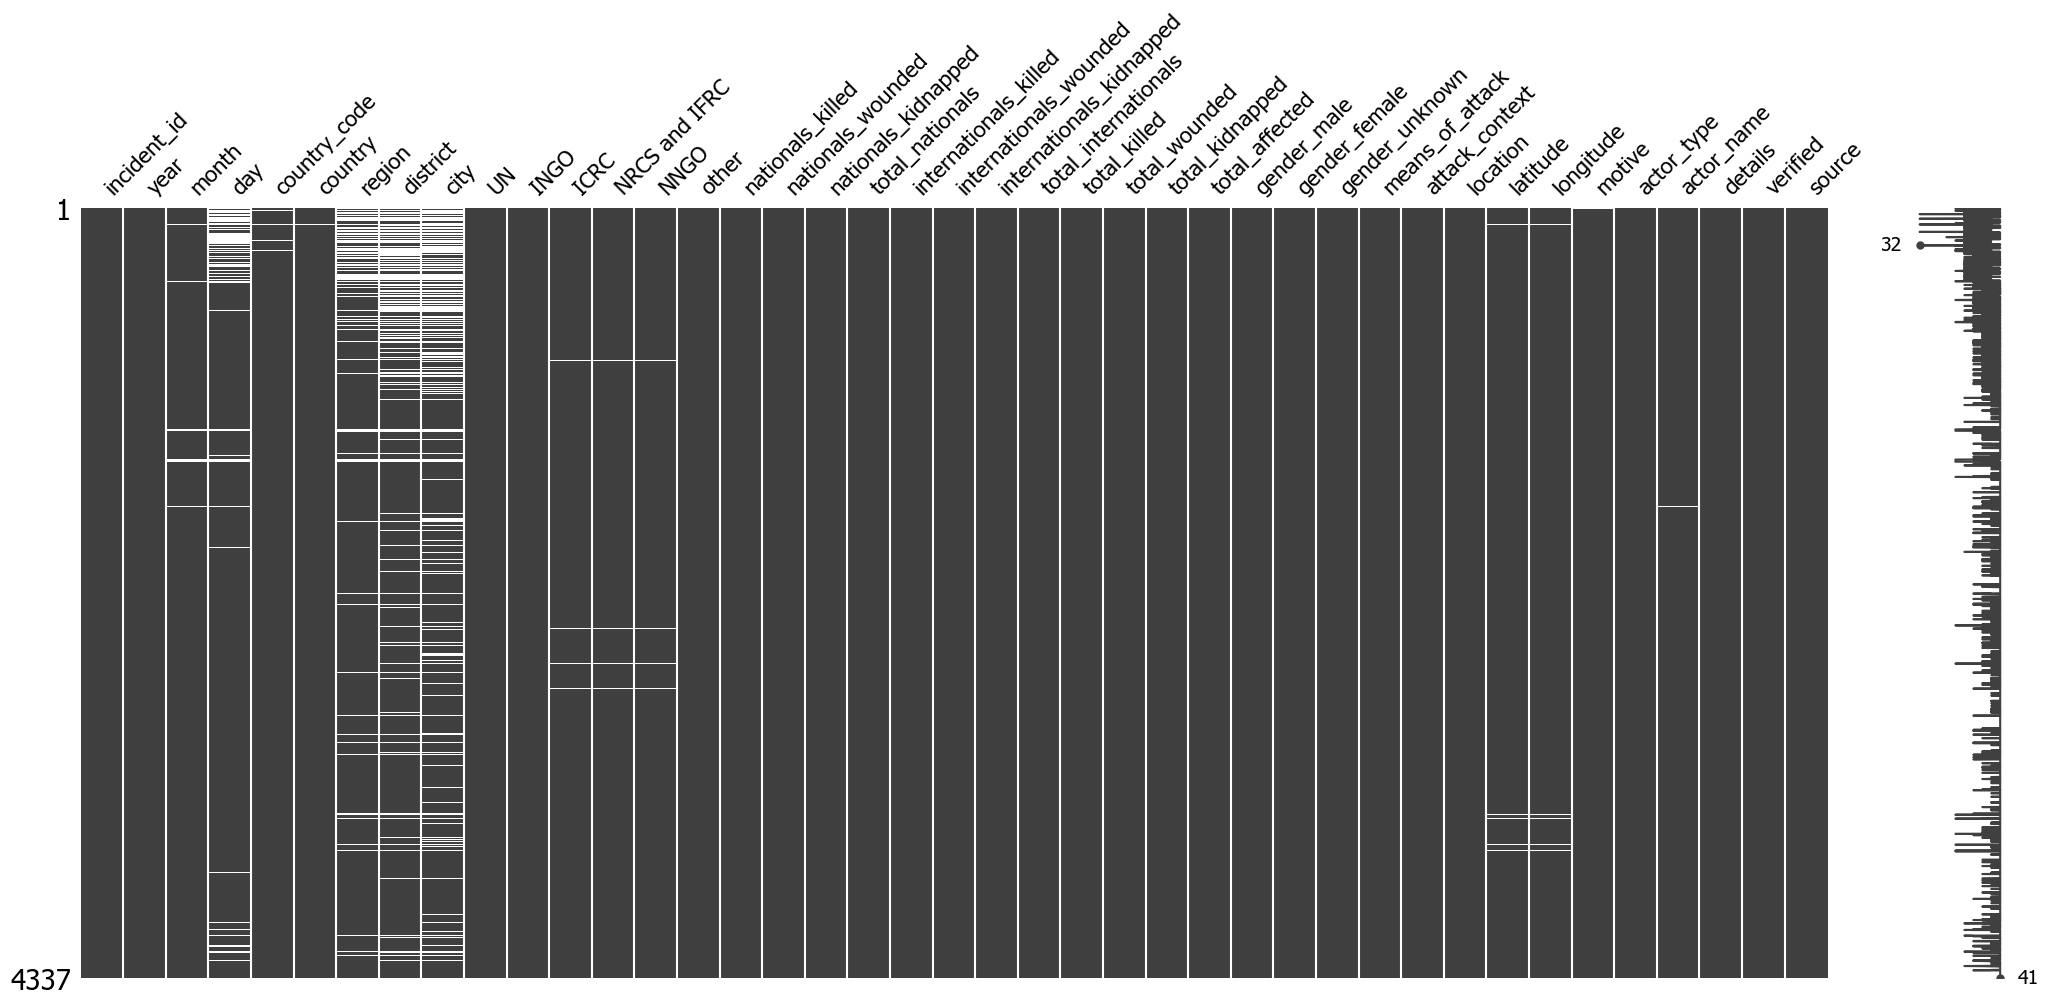

In [10]:
import missingno as msno

msno.matrix(df)

### Exploring Missing Data Patterns

Exploring patterns in missing data is important for identifying dependencies between variables and making better cleaning decisions. The matrix heatmap above shows where values are missing across the dataset. The correlation heatmap below goes further, showing which fields tend to be missing together. This helps avoid careless deletions or assumptions when handling missing data, and supports a more informed cleanup process.

<Axes: >

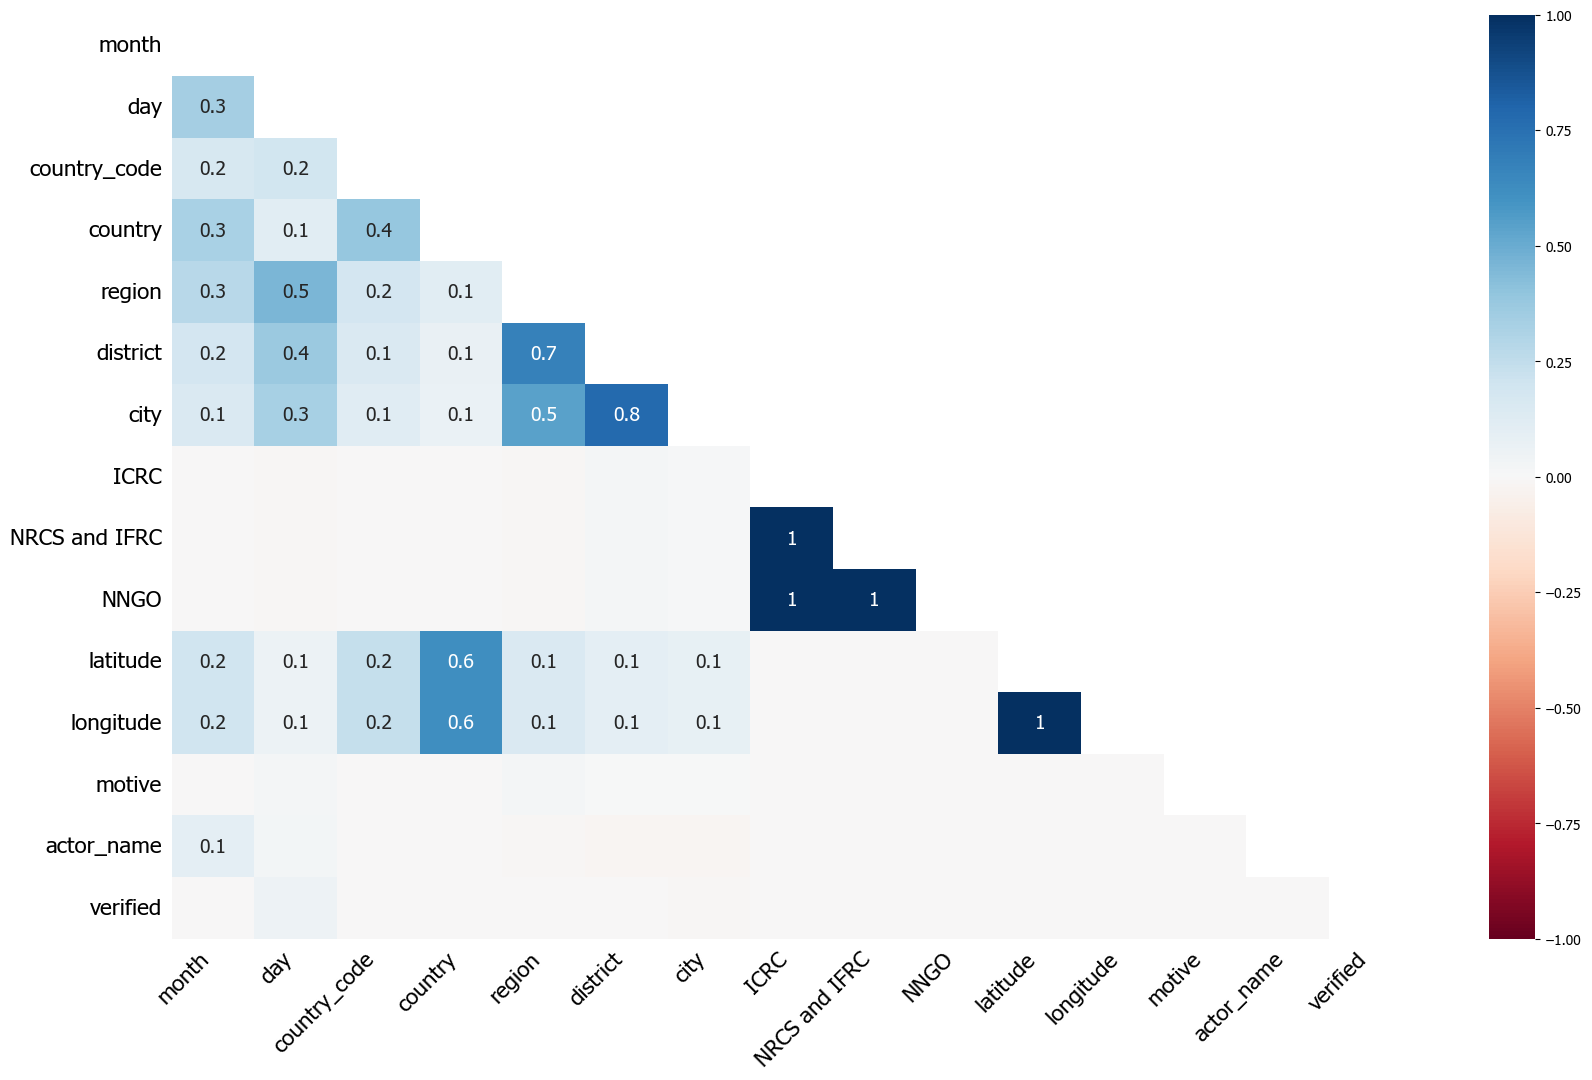

In [11]:
msno.heatmap(df)

The missing data in this dataset appears to be **Missing at Random (MAR)**, which means the likelihood of a value being missing is related to other observed variables in the dataset, rather than the missing value itself. Evidence for this includes the observed dependencies between fields with missing data.

- `city` and `district` demonstrate a strong correlation in missing data, suggesting that when one is missing, the other is likely to be missing as well. 
- There are moderate correlations between `city` and `region`, as well as `district` and `region`, which indicates that missing data in these fields often occur together, reflecting challenges in documenting comprehensive geographic details in some records.
- Both `latitude` and `longitude` show a strong correlation with each other and moderate correlation with `country_code` and `country`, which could imply that missing geographic coordinates are related to missing or incorrect country coding.
- The missing `day` data, while not strongly correlated with any single geographic field, is often concurrently missing when `region`, `district`, and `city` data are absent, a pattern that underscores the challenges in recording accurate and complete information in chaotic environments. 

### Dropping Data

**Data Dropping Decisions**
1. Dropping rows where both `latitude` and `longitude` are missing ensures that all entries have necessary data for location-specific analysis. Interestingly, this step also removed all entries missing the country field, which aligns with ensuring geographic accuracy. Given that only 13 records were affected, this represents a minor portion (approximately 0.29%) of the dataset, minimizing the impact on the overall data integrity and availability for analysis.

2. Dropping rows where both `day` and `month` are missing because complete date information is important for temporal patterns and analysis. As in conflict zones, immediate crisis response can prioritize medical aid over detailed record-keeping, ensuring the availability of at least partial date information helps in maintaining a minimal level of temporal analysis capability.

3. Considering the chaotic environments in which this data is collected, the simultaneous absence of multiple key pieces of information, `day`, `region`, `district`, `city` in the same record could indicate recording challenges and also potentially lower reliability or raise uncertainty in these specific entries. Further, given the correlation among these fields and their collective importance for any geographic or temporal analysis, dropping these rows was necessary to enhance the reliability of the dataset.

In [12]:
# Drop rows where latitude, longitude are missing
df.dropna(subset=["latitude", "longitude"], how="all", inplace=True)

# Drop rows where day and month are missing
df.dropna(subset=["day", "month"], inplace=True)

# Drop rows where day, region, district, and city are all missing
df.dropna(subset=["day", "region", "district", "city"], how="all", inplace=True)

# Print the number of rows after dropping
print("Number of rows after dropping specified missing data:", df.shape[0], "\n")

Number of rows after dropping specified missing data: 3949 



### Filling in Missing Data
#### Geographic Data using `Nominatim`
Reverse geocoding through GeoPy's [**Nominatim API**](https://nominatim.org/release-docs/3.6/api/Reverse/){target="_blank"} will be used to populate missing geographic data in which there are missing values in the `city`, `district`, and `region` fields but `latitude` and `longitude` coordinates are available. 

First, a boolean mask is created to identify rows where at least one of the location fields is null while valid latitude and longitude values are present which allows the reverse geocoding process to run only on rows that have coordinates available for lookup.

In [13]:
mask = (
    df[["city", "district", "region"]].isna().any(axis=1)
    & df["latitude"].notna()
    & df["longitude"].notna()
)

print("Rows with missing city/district/region but with valid lat/long:", mask.sum())

Rows with missing city/district/region but with valid lat/long: 762


In [14]:
from geopy.geocoders import Nominatim
from time import sleep

geolocator = Nominatim(user_agent="geo_cleaner_25")


def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse(
            (lat, lon), timeout=10, language="en"
        )  # force English
        if location and location.raw.get("address"):
            address = location.raw["address"]
            return {
                "city": address.get("city")
                or address.get("town")
                or address.get("village"),
                "district": address.get("county"),
                "region": address.get("state"),
            }
    except:
        return None


# Apply to missing rows (throttle with sleep to avoid being blocked)
filled = []
for idx, row in df[mask].iterrows():
    result = reverse_geocode(row["latitude"], row["longitude"])
    if result:
        for key in ["city", "district", "region"]:
            if pd.isna(df.at[idx, key]) and result.get(key):
                df.at[idx, key] = result[key]
    sleep(1)  # Nominatim rate limit

In [15]:
print("Remaining missing values:")
print(df[["city", "district", "region"]].isna().sum())

updated_mask = mask & df[["city", "district", "region"]].notna().any(axis=1)

print("Rows successfully updated with at least one field:", updated_mask.sum())

Remaining missing values:
city        264
district    178
region       15
dtype: int64
Rows successfully updated with at least one field: 761


In [16]:
# Fill remaining geographic missing data with Unknown
df["district"].fillna("Unknown", inplace=True)
df["city"].fillna("Unknown", inplace=True)
df["region"].fillna("Unknown", inplace=True)

##### Standardizing  Newly Added Geographic Data
To standardize newly added geographic names, accented characters were replaced with their unaccented equivalents using a custom mapping function. This step helps avoid inconsistencies caused by special characters in the dataset. Quotation marks and commas were also removed from location fields to prevent parsing issues and ensure consistent text formatting.

In [17]:
import re

# Dictionary to replace accented characters with plain equivalents
replacements = {
    "é": "e",
    "è": "e",
    "ê": "e",
    "á": "a",
    "í": "i",
    "ó": "o",
    "ú": "u",
    "ñ": "n",
}


# Replace accented characters
def replace_accents(text):
    if isinstance(text, str):
        for accented_char, replacement in replacements.items():
            text = text.replace(accented_char, replacement)
        return text
    return text


df = df.applymap(replace_accents)

# Characters to remove from location fields
unwanted_chars = ['"', ","]


# Clean unwanted characters and remove anything in parentheses
def clean_location_text(text):
    if isinstance(text, str):
        for char in unwanted_chars:
            text = text.replace(char, "")
        # Remove "(near)" and anything similar in parentheses
        text = re.sub(r"\s*\(.*?\)", "", text)
    return text


# Apply cleaning to city, district, and region columns
for col in ["city", "district", "region"]:
    df[col] = df[col].apply(clean_location_text)

#### Country Codes

In [18]:
missing_country_code = df[df[["country_code"]].isna().all(axis=1)]
print("Unique countries where 'country_code' is missing:")
print(missing_country_code["country"].unique())

Unique countries where 'country_code' is missing:
['Chechnya' 'Namibia']


Source: [ISO Country Codes](https://www.iso.org/obp/ui/#search){target="_blank"}

In [19]:
country_code_mapping = {"Namibia": "NA", "Chechnya": "RU-CE"}

df.loc[df["country"].isin(["Namibia", "Chechnya"]), "country_code"] = df["country"].map(
    country_code_mapping
)

#### Remaining Missing Data

In [20]:
df["motive"].fillna("Unknown", inplace=True)
df["actor_name"].fillna("Unknown", inplace=True)
df["verified"].fillna(
    "No", inplace=True
)  # If not "yes", "archived", or "pending" which are the available values then the assumption is no, there is only one NA for "Verified" so this feels safe.

# Check remaining missing data summary
print(df.isna().sum())

incident_id                 0
year                        0
month                       0
day                         0
country_code                0
country                     0
region                      0
district                    0
city                        0
UN                          0
INGO                        0
ICRC                        9
NRCS and IFRC               9
NNGO                        9
other                       0
nationals_killed            0
nationals_wounded           0
nationals_kidnapped         0
total_nationals             0
internationals_killed       0
internationals_wounded      0
internationals_kidnapped    0
total_internationals        0
total_killed                0
total_wounded               0
total_kidnapped             0
total_affected              0
gender_male                 0
gender_female               0
gender_unknown              0
means_of_attack             0
attack_context              0
location                    0
latitude  

Now there are only three remaining variables with missing data: `ICRC`, `NRCS and IFRC`, and `NNGO`. Examination of these fields revealed that all three fields are simultaneously missing in 9 instances. 

To maintain dataset integrity without dropping potentially valuable data, a placeholder will be introduced with a value of `100` for these missing entries. This method allows for the retention of these records in the analysis while clearly marking them for easy exclusion during analytical phases where accurate incident counts are necessary.

Here are the unique values currently in these fields:

In [21]:
print("Unique values in 'ICRC':", df["ICRC"].unique())
print("Unique values in 'NRCS and IFRC':", df["NRCS and IFRC"].unique())
print("Unique values in 'NNGO':", df["NNGO"].unique())

Unique values in 'ICRC': [ 0.  1.  7.  6.  2.  4. nan  3.  8.  5.]
Unique values in 'NRCS and IFRC': [ 0.  3.  4.  1.  2.  6. 14. nan 15.  7. 11.  5. 10. 18. 19.  9.]
Unique values in 'NNGO': [ 0.  3.  1.  4.  5.  2.  8. nan 12.  6.  7. 10. 11. 14.  9. 15.]


In [22]:
# Fill missing values with 100 for specific columns
df["ICRC"] = df["ICRC"].fillna(100)
df["NRCS and IFRC"] = df["NRCS and IFRC"].fillna(100)
df["NNGO"] = df["NNGO"].fillna(100)

In [23]:
# Check remaining missing data summary
print(df.isna().sum())
# Print the number of rows after dropping
print("Number of rows:", df.shape[0], "\n")

incident_id                 0
year                        0
month                       0
day                         0
country_code                0
country                     0
region                      0
district                    0
city                        0
UN                          0
INGO                        0
ICRC                        0
NRCS and IFRC               0
NNGO                        0
other                       0
nationals_killed            0
nationals_wounded           0
nationals_kidnapped         0
total_nationals             0
internationals_killed       0
internationals_wounded      0
internationals_kidnapped    0
total_internationals        0
total_killed                0
total_wounded               0
total_kidnapped             0
total_affected              0
gender_male                 0
gender_female               0
gender_unknown              0
means_of_attack             0
attack_context              0
location                    0
latitude  

Now all of the missing data has been handled while maintaining the integrity of the data! 

## Data Type Optimization

In [24]:
print(df.dtypes)

incident_id                   int64
year                          int64
month                       float64
day                         float64
country_code                 object
country                      object
region                       object
district                     object
city                         object
UN                            int64
INGO                          int64
ICRC                        float64
NRCS and IFRC               float64
NNGO                        float64
other                         int64
nationals_killed              int64
nationals_wounded             int64
nationals_kidnapped           int64
total_nationals               int64
internationals_killed         int64
internationals_wounded        int64
internationals_kidnapped      int64
total_internationals          int64
total_killed                  int64
total_wounded                 int64
total_kidnapped               int64
total_affected                int64
gender_male                 

In [25]:
# Convert fields that represent counts to int
df["ICRC"] = df["ICRC"].astype(int)
df["NRCS and IFRC"] = df["NRCS and IFRC"].astype(int)
df["NNGO"] = df["NNGO"].astype(int)

### Date Conversion and Creating DateTime
To streamline analysis, separate year, month, and day columns were combined into a single date column using pd.to_datetime(). These columns were then dropped to keep the dataset tidy.

In [26]:
# Convert to integers
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)

# New date column from year, month, and day
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

df.drop(["year", "month", "day"], axis=1, inplace=True)

In [27]:
# Move date column after incident_id and before country_code
cols = df.columns.tolist()

# Remove date from current position
cols.remove("date")

# Find index of incident_id
idx = cols.index("incident_id") + 1
cols.insert(idx, "date")

# Reorder the dataframe
df = df[cols]
df.head()

,incident_id,date,country_code,country,region,district,city,UN,INGO,ICRC,...,attack_context,location,latitude,longitude,motive,actor_type,actor_name,details,verified,source
4,5,1997-02-14,RW,Rwanda,Kigali,Kigali,Kigali,1,0,0,...,Individual attack,Unknown,-1.950851,30.061508,Political,Unknown,Unknown,1 UN national staff shot and killed in Kigali ...,Archived,Archived
6,6,1997-05-07,SL,Sierra Leone,Tonkolili District,Unknown,Mayamba,3,0,0,...,Ambush,Road,8.640035,-11.840027,Unknown,Unknown,Unknown,1 UN national staff driver killed and 2 UN nat...,Archived,Archived
8,12,1997-06-08,RW,Rwanda,Northern,Musanze,Ruhengeri,0,1,0,...,Combat/Crossfire,Unknown,-1.499840,29.634970,Incidental,Unknown,Unknown,1 INGO national staff killed when he was among...,Archived,Archived
9,8,1997-06-14,RW,Rwanda,Northern,Musanze,Ruhengeri,1,0,0,...,Individual attack,Home,-1.499840,29.634970,Political,Non-state armed group: Unknown,Not applicable,1 UN national staff shot and killed in Ruhenge...,Archived,Archived
10,9,1997-06-17,RW,Rwanda,Northern,Musanze,Ruhengeri,1,0,0,...,Detention,Unknown,-1.499840,29.634970,Political,Unknown,Unknown,1 UN national staff shot and killed in Ruhenge...,Archived,Archived


In [28]:
print(f"Number of rows: {len(df)}")

Number of rows: 3949


## Save Cleaned CSV

In [29]:
# Save to a CSV file
df.to_csv("data/clean_data/cleaned_security_incidents.csv", index=False)